# Setup

## Libraries

In [1]:
# Data wrangling
import numpy as np
import pandas as pd

# Data visualization
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

# Preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer, OrdinalEncoder, OneHotEncoder

# Statistical tests
from scipy import stats

# Models
from prince import MCA, FAMD
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegressionCV

# Models Pipelines
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.pipeline import make_pipeline, Pipeline

# Model evaluation
import time
from sklearn import metrics
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split, GridSearchCV

# # Set output as pandas
# from sklearn import set_config
# set_config(transform_output="pandas")

## Library settings

In [2]:
# see rc Params on https://matplotlib.org/stable/tutorials/introductory/customizing.html
# or just take a look at plt.rcParams
sns.set_theme(
    context='talk',
    style='ticks',
    font_scale=.8,
    rc={
        'figure.figsize': (12,8),
        'axes.grid': True,
        'grid.alpha': .2,
        'axes.labelpad': 20,
        'axes.titlepad': 30
    }
)

## Custom functions

In [3]:
def bootstrap_chi2(df, cat_col1, cat_col2, expected=False, n_boostrap=1_000, ci=.95):
    ci_lower = np.round((1-ci)/2, 3)
    ci_upper = 1 - ci_lower
    
    bootstrap_values = []
    for i in range(n_boostrap):
        df_sample = df.sample(frac=1, replace=True)
        df_sample_crosstab = pd.crosstab(df_sample[cat_col1], df_sample[cat_col2])
        if expected:
            bootstrap_values.append(stats.chi2_contingency(df_sample_crosstab)[-1])
        else:
            bootstrap_values.append(df_sample_crosstab)
    
    bootstrap_values_pct = [boostrap_sample / boostrap_sample.sum() for boostrap_sample in bootstrap_values]
    
    ci_array = np.quantile(a=np.array(bootstrap_values), q=[ci_lower,ci_upper], axis=0).round().astype(int)
    ci_array_pct = np.quantile(a=np.array(bootstrap_values_pct), q=[ci_lower,ci_upper], axis=0).round(2)
    
    return ci_array, ci_array_pct


def make_heatmap_freqlabel(df, index, columns, expected=False, bootstrap=False, **kwargs):
    df_crosstab = pd.crosstab(df[index], df[columns])
    
    if expected:
        df_crosstab = (
            pd.DataFrame(stats.chi2_contingency(df_crosstab)[-1], index=df_crosstab.index, columns=df_crosstab.columns)
            .round().astype(int)
        )
    
    df_crosstab_str = df_crosstab.astype(str)
    df_crosstab_str_pct = (df_crosstab / df_crosstab.sum().sum()*100).round().astype(int).astype(str)+'%'
    
    if bootstrap:
        ci = bootstrap_chi2(df, index, columns, expected, **kwargs)
        df_crosstab_str = df_crosstab_str + '\n(' + ci[0][0].astype(str) + ' - ' + ci[0][1].astype(str) + ')'
        
        ci_lower_pct = (ci[1][0]*100).astype(int).astype(str)
        ci_upper_pct = (ci[1][1]*100).astype(int).astype(str)
        df_crosstab_str_pct = df_crosstab_str_pct + '\n(' + ci_lower_pct + '% - ' + ci_upper_pct + '%)'
        
    return df_crosstab_str + '\n\n' + df_crosstab_str_pct


def plot_heatmap(df, index, columns, bootstrap=False):
    df_absfreq = pd.crosstab(df[index], df[columns])
    df_absfreq_expected = pd.DataFrame(stats.chi2_contingency(df_absfreq)[-1], index=df_absfreq.index, columns=df_absfreq.columns).round().astype(int)

    plot_title = f'{index} vs {columns}'
    fig, ax = plt.subplots(ncols=2, figsize=(14,7))

    ax1 = sns.heatmap(df_absfreq, cmap='Blues', annot=make_heatmap_freqlabel(df, index, columns), fmt='', cbar=False, ax=ax[0],linewidths=.5)
    ax1.text(x=0.5, y=1.1, s=plot_title, fontsize='large', weight='bold', ha='center', va='bottom', transform=ax1.transAxes)
    ax1.text(x=0.5, y=1.04, s='Observed values', fontsize='small', alpha=0.75, ha='center', va='bottom', transform=ax1.transAxes)
    ax1.tick_params(left=False)

    ax2 = sns.heatmap(df_absfreq_expected, cmap='Blues', annot=make_heatmap_freqlabel(df, index, columns, bootstrap=bootstrap, expected=True), cbar=False, fmt='', ax=ax[1], linewidths=.5)
    ax2.text(x=0.5, y=1.1, s=plot_title, fontsize='large', weight='bold', ha='center', va='bottom', transform=ax2.transAxes)
    ax2.text(x=0.5, y=1.04, s='Expected values under independent-association hypothesis', fontsize='small', alpha=0.75, ha='center', va='bottom', transform=ax2.transAxes)
    ax2.tick_params(left=False)
    ax2.set_ylabel(None)
    ax2.set_yticks([])

    plt.tight_layout(w_pad=3)
    plt.show()
    
    
def plot_chi2(df, index, columns, ax=None):
    # Get observed chi2 and dof
    chi2, p, dof, expected = stats.chi2_contingency(pd.crosstab(df[index], df[columns]))
    # Get theoretical chi2 distribution
    theorical_chi2_dist = np.random.chisquare(dof, df.shape[0])

    # Plot
    # plt.figure(figsize=(9,6))
    sns.histplot(theorical_chi2_dist, kde=True, color='orange', alpha=.3, stat='density', ax=ax)
    ax.axvline(chi2, ls='--', color='black', ymax=.9, label=f'$\chi^2$ = {chi2:.2f}')
    plt.legend(loc='upper right', prop={'size':'small'}, frameon=False)
    
    ax.set_title(f'{index} vs {columns}', y=1.05, weight='bold', size=14)
    ax.annotate(f'P(X > {chi2:.2f}) = {1-stats.chi2.cdf(chi2, dof):.4f}', xy=(.5,1.06), xycoords='axes fraction', ha='center')
    
    sns.despine(offset=10, trim=True, ax=ax)
    return ax


def calculate_missing_values(df, show_missing_only=False):
    df_missing = (
        df.isna().sum().to_frame('missing_count')
        .assign(missing_pct = lambda x: x.missing_count / df.shape[0])
        .sort_values('missing_count', ascending=False)
        
        )
    if show_missing_only:
        df_missing = df_missing.query('missing_count>0').style.format('{:.2%}', subset='missing_pct')
    else:
        df_missing.style.format('{:.2%}', subset='missing_pct')
    return df_missing


def get_metrics(y_true, y_pred, y_proba=None):
    dict_metrics = {
        'Accuracy': metrics.accuracy_score(y_true, y_pred),
        'Balanced Accuracy': metrics.balanced_accuracy_score(y_true, y_pred),
        'Recall': metrics.recall_score(y_true, y_pred),
        'Precison': metrics.precision_score(y_true, y_pred),
        'F1': metrics.f1_score(y_true, y_pred),
    }
    
    if y_proba is not None:
        dict_metrics['ROC_AUC'] = metrics.roc_auc_score(y_true, y_proba)
    
    return dict_metrics


def entropy(data, target_col):
    label_counts = data[target_col].value_counts(normalize=True)
    return -np.sum(label_counts * np.log2(label_counts))


def information_gain(data, target_col, attribute_col):
    initial_entropy = entropy(data, target_col)
    
    attribute_values = data[attribute_col].unique()
    attribute_entropy = 0
    
    for value in attribute_values:
        value_data = data[data[attribute_col] == value]
        value_weight = len(value_data) / len(data)
        attribute_entropy += value_weight * entropy(value_data, target_col)
    
    return initial_entropy - attribute_entropy


def calculate_proportion(df, value_col, group_col):
    df_prop = df.pivot_table(index=group_col, columns=value_col, aggfunc='size')
    df_prop = df_prop.apply(lambda x: x / x.sum(), axis=1)
    return df_prop

## Load dataset

In [4]:
# Load data
df = pd.read_csv('../data/processed/customer_churn.csv', index_col='CustomerID')
display(df)

,Count,Country,State,City,Zip Code,Lat Long,Latitude,Longitude,Gender,Senior Citizen,...,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Label,Churn Value,Churn Score,CLTV,Churn Reason,Churn
CustomerID,,,,,,,,,,,,,,,,,,,,,
3668-QPYBK,1,United States,California,Los Angeles,90003,"33.964131, -118.272783",33.964131,-118.272783,Male,No,...,Yes,Mailed check,53.85,108.15,Yes,1,86,3239,Competitor made better offer,1
9237-HQITU,1,United States,California,Los Angeles,90005,"34.059281, -118.30742",34.059281,-118.307420,Female,No,...,Yes,Electronic check,70.70,151.65,Yes,1,67,2701,Moved,1
9305-CDSKC,1,United States,California,Los Angeles,90006,"34.048013, -118.293953",34.048013,-118.293953,Female,No,...,Yes,Electronic check,99.65,820.50,Yes,1,86,5372,Moved,1
7892-POOKP,1,United States,California,Los Angeles,90010,"34.062125, -118.315709",34.062125,-118.315709,Female,No,...,Yes,Electronic check,104.80,3046.05,Yes,1,84,5003,Moved,1
0280-XJGEX,1,United States,California,Los Angeles,90015,"34.039224, -118.266293",34.039224,-118.266293,Male,No,...,Yes,Bank transfer (automatic),103.70,5036.30,Yes,1,89,5340,Competitor had better devices,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2569-WGERO,1,United States,California,Landers,92285,"34.341737, -116.539416",34.341737,-116.539416,Female,No,...,Yes,Bank transfer (automatic),21.15,1419.40,No,0,45,5306,NaN,0
6840-RESVB,1,United States,California,Adelanto,92301,"34.667815, -117.536183",34.667815,-117.536183,Male,No,...,Yes,Mailed check,84.80,1990.50,No,0,59,2140,NaN,0
2234-XADUH,1,United States,California,Amboy,92304,"34.559882, -115.637164",34.559882,-115.637164,Female,No,...,Yes,Credit card (automatic),103.20,7362.90,No,0,71,5560,NaN,0


# Data Understanding

In [5]:
df.describe()

,Count,Zip Code,Latitude,Longitude,Tenure Months,Monthly Charges,Total Charges,Churn Value,Churn Score,CLTV,Churn
count,7032.0,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000
mean,1.0,93523.032565,36.283307,-119.799215,32.421786,64.798208,2283.300441,0.265785,58.715301,4401.445108,0.265785
std,0.0,1865.515958,2.456118,2.157588,24.545260,30.085974,2266.771362,0.441782,21.531321,1182.414266,0.441782
min,1.0,90001.000000,32.555828,-124.301372,1.000000,18.250000,18.800000,0.000000,5.000000,2003.000000,0.000000
25%,1.0,92102.000000,34.030915,-121.815412,9.000000,35.587500,401.450000,0.000000,40.000000,3469.750000,0.000000
50%,1.0,93552.500000,36.391777,-119.735410,29.000000,70.350000,1397.475000,0.000000,61.000000,4527.500000,0.000000
75%,1.0,95354.000000,38.227285,-118.043237,55.000000,89.862500,3794.737500,1.000000,75.000000,5381.000000,1.000000
max,1.0,96161.000000,41.962127,-114.192901,72.000000,118.750000,8684.800000,1.000000,100.000000,6500.000000,1.000000


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 3668-QPYBK to 3186-AJIEK
Data columns (total 33 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Count              7032 non-null   int64  
 1   Country            7032 non-null   object 
 2   State              7032 non-null   object 
 3   City               7032 non-null   object 
 4   Zip Code           7032 non-null   int64  
 5   Lat Long           7032 non-null   object 
 6   Latitude           7032 non-null   float64
 7   Longitude          7032 non-null   float64
 8   Gender             7032 non-null   object 
 9   Senior Citizen     7032 non-null   object 
 10  Partner            7032 non-null   object 
 11  Dependents         7032 non-null   object 
 12  Tenure Months      7032 non-null   int64  
 13  Phone Service      7032 non-null   object 
 14  Multiple Lines     7032 non-null   object 
 15  Internet Service   7032 non-null   object 
 16  Online Securit

In [7]:
# Verify duplicated values
df.index.duplicated().any()

False

In [8]:
# Check missing values
calculate_missing_values(df, show_missing_only=True)

,missing_count,missing_pct
Churn Reason,5163,73.42%


In [9]:
# Check churn value
df['Churn'].value_counts()

Churn
0    5163
1    1869
Name: count, dtype: int64

In [10]:
# Percent
df['Churn'].eq(0).sum() / df.shape[0]

0.7342150170648464

In [11]:
# Percent target class
df['Churn'].eq(1).sum() / df.shape[0]

0.26578498293515357

# EDA

In [12]:
df = df.drop(columns=['Count','Country','State', 'City', 'Zip Code', 'Lat Long', 'Churn Label', 'Churn Value', 'Churn Score', 'Churn Reason'])

### Target class distribution

In [13]:
churn_count = df['Churn'].astype(bool).astype(str).value_counts()
churn_pct = df['Churn'].astype(bool).astype(str).value_counts(normalize=True)

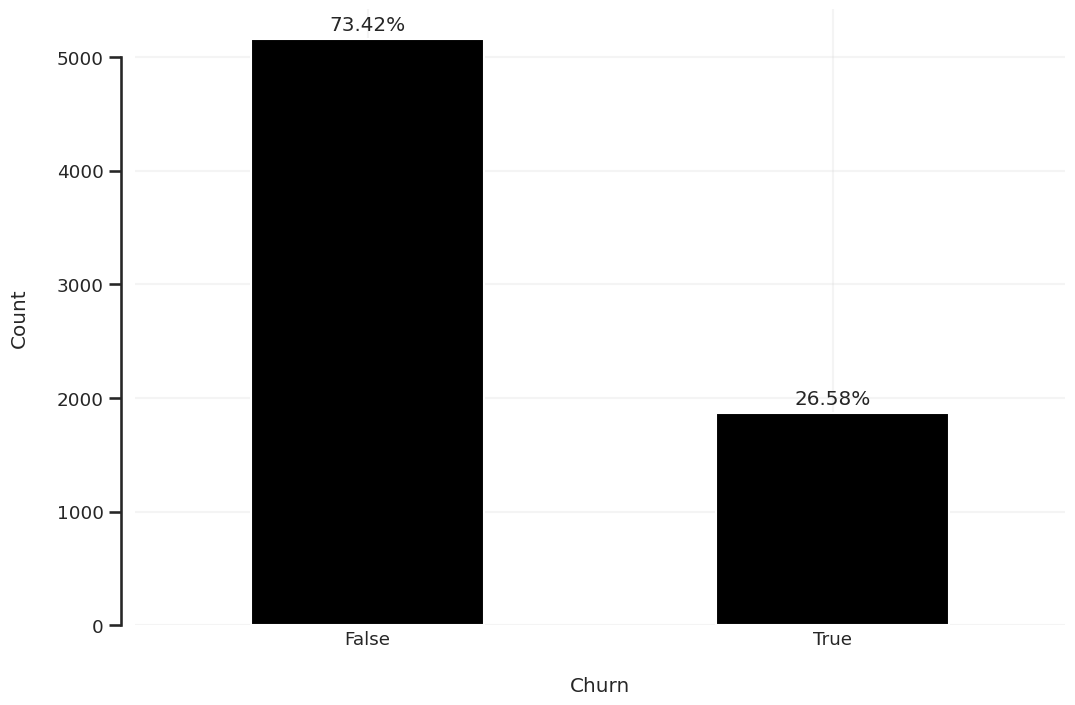

In [14]:
fig,ax = plt.subplots()

churn_count.plot.bar(color='black', ax=ax)
plt.xlabel('Churn')
plt.ylabel('Count')
plt.xticks(rotation=0)

# Loop through the bars and add annotations
for p,l in zip(ax.patches,ax.get_xticklabels()):
    height = p.get_height()
    pct_text = churn_pct[l.get_text()]
    ax.annotate(
        f'{pct_text:.2%}', xy=(p.get_x() + p.get_width() / 2, height), xytext=(0, 3),
        textcoords="offset points", ha='center', va='bottom'
    )

ax.tick_params(axis='x', which='both', length=0)
    
sns.despine(bottom=True, trim=True, offset=10)
plt.show()

### Categorical variables vs target

In [15]:
categorical_columns = df.select_dtypes('object').columns.tolist()
numerical_columns = df.select_dtypes('number').columns.tolist()
numerical_columns = [num_col for num_col in numerical_columns if num_col != 'Churn']

In [16]:
df_chi2 = (
    pd.DataFrame(
        {cat_col: stats.chi2_contingency(pd.crosstab(df[cat_col], df['Churn']), correction=True)[:2] for cat_col in categorical_columns},
        index=['chi2','pvalue']
    )
    .transpose()
    .sort_values('chi2', ascending=False)    
)

df_chi2_styled = df_chi2.style.background_gradient(cmap='Oranges')

print("""
Valores de qui-quadrado para cada variável em relação ao Churn.
Para p-valores menores que 0.05 podemos considerar que há associação.
""")
display(df_chi2_styled)


Valores de qui-quadrado para cada variável em relação ao Churn.
Para p-valores menores que 0.05 podemos considerar que há associação.



,chi2,pvalue
Contract,1179.545829,0.000000
Online Security,846.677389,0.000000
Tech Support,824.925564,0.000000
Internet Service,728.695614,0.000000
Payment Method,645.429900,0.000000
Online Backup,599.175185,0.000000
Device Protection,555.880327,0.000000
Dependents,431.652736,0.000000
Streaming Movies,374.268432,0.000000
Streaming TV,372.456502,0.000000


In [17]:
# Save table to excel file
# df_chi2.rename_axis('Categorical Variable').to_excel('../reports/tables/chi2.xlsx')

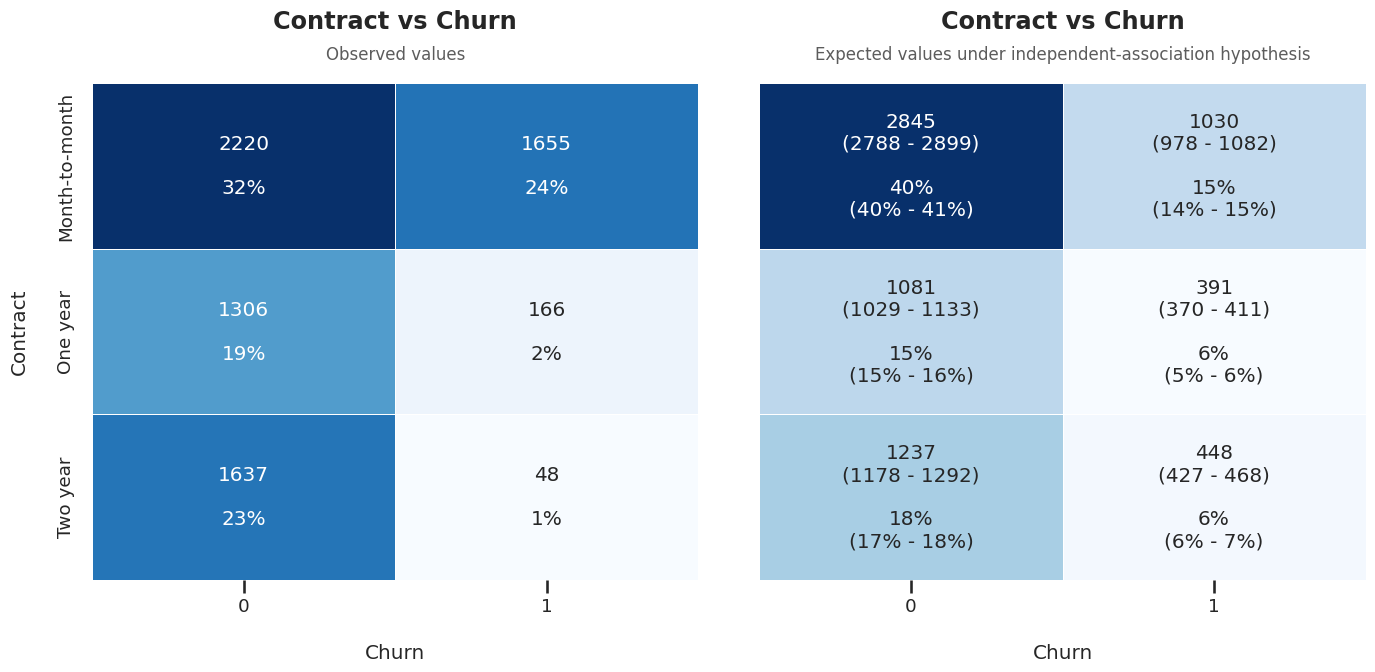

In [18]:
plot_heatmap(df, index='Contract', columns='Churn', bootstrap=True)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


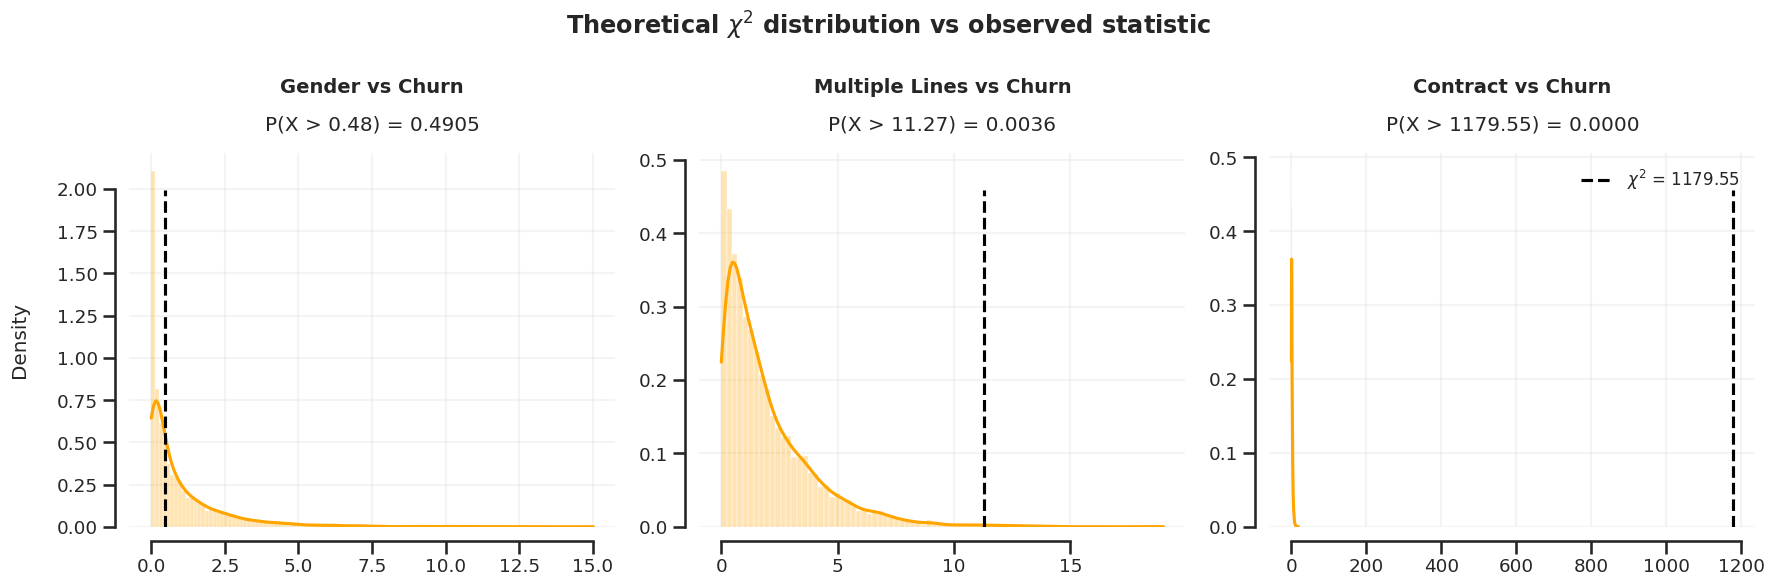

In [19]:
fig,axes = plt.subplots(ncols=3, figsize=(18,6))
plot_chi2(df, 'Gender', 'Churn', axes[0])
plot_chi2(df, 'Multiple Lines', 'Churn', axes[1])
plot_chi2(df, 'Contract', 'Churn', axes[2])


fig.suptitle('Theoretical $\chi^2$ distribution vs observed statistic', weight='bold')

axes[1].set_ylabel(None)
axes[2].set_ylabel(None)
plt.tight_layout()
plt.show()

### Numerical variables vs target

In [20]:
df_melt = df[numerical_columns+['Churn']].melt(id_vars=['Churn'])
df_melt['Churn'] = df_melt['Churn'].astype(bool)

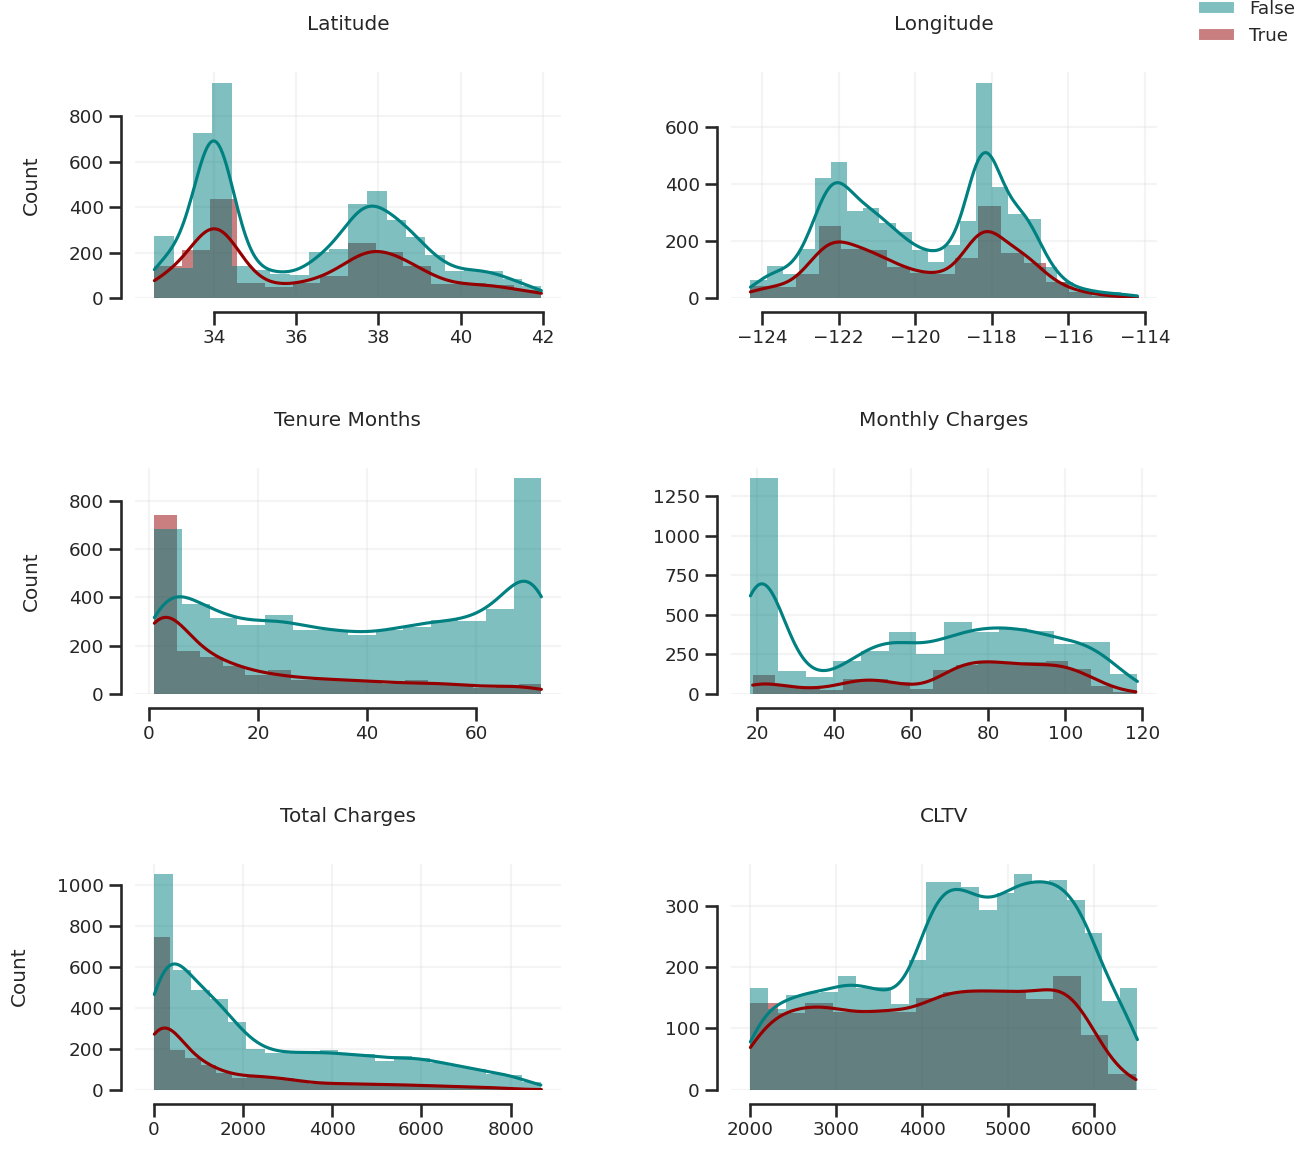

In [21]:
g = sns.displot(
    data=df_melt, x='value', hue='Churn', col='variable', col_wrap=2, kde=True, palette=['teal', '#940000'], common_bins=False,
    facet_kws={'sharex': False, 'sharey': False}, height=4, aspect=1.5
)

g.set_titles('{col_name}')
g.fig.subplots_adjust(hspace=.75, wspace=.4)

for ax in g.axes.flat:
    ax.set_xlabel('')

legend = g._legend
legend.set_bbox_to_anchor((1., .95))
legend.set_title('Churn')
legend.get_title().set_fontsize(12)
legend.get_title().set_weight('bold')

sns.despine(trim=True, offset=10)
plt.show()

In [22]:
stat_results = []

for numeric_col in numerical_columns:

    # For T test
    a = df.loc[df['Churn']==0, numeric_col]
    b = df.loc[df['Churn']==1, numeric_col]
    ttest_result = stats.ttest_ind(a, b)

    # For Wilcoxon test
    min_sample = min(a.size, b.size)
    a_sample = a.sample(min_sample)
    b_sample = b.sample(min_sample)
    wilcoxon_result = stats.wilcoxon(a_sample, b_sample)
    
    # Save statistical results
    result = list(ttest_result) + list(wilcoxon_result)
    stat_results.append(result)


In [23]:
stat_column_names = pd.MultiIndex.from_tuples([
    ('T-test', 'T-statistic'),
    ('T-test', 'p-value'),
    ('Wilcoxon signed-rank test', 'Wilcoxon statistic'),
    ('Wilcoxon signed-rank test', 'p-value'),
])

In [24]:
df_numerical_stats = pd.DataFrame(stat_results, index=numerical_columns, columns=stat_column_names).rename_axis('Variable')
df_numerical_stats = df_numerical_stats.sort_values(('T-test','p-value'))

In [25]:
df_numerical_stats

T-test                Wilcoxon signed-rank test  \
                T-statistic        p-value        Wilcoxon statistic   
Variable                                                               
Tenure Months     31.741289  9.437650e-207                  325239.5   
Total Charges     17.068827   4.876866e-64                  519177.0   
Monthly Charges  -16.479593   6.760843e-60                  572126.0   
CLTV              10.842939   3.532130e-27                  627196.5   
Longitude         -0.393470   6.939842e-01                  848806.0   
Latitude           0.301806   7.628092e-01                  844834.5   

                                
                       p-value  
Variable                        
Tenure Months    5.742082e-114  
Total Charges     3.783000e-52  
Monthly Charges   4.695116e-38  
CLTV              4.265777e-26  
Longitude         3.217766e-01  
Latitude          2.151612e-01

In [26]:
# Save table to excel file
# df_numerical_stats.to_excel('../reports/tables/numerical_stats.xlsx')

[]

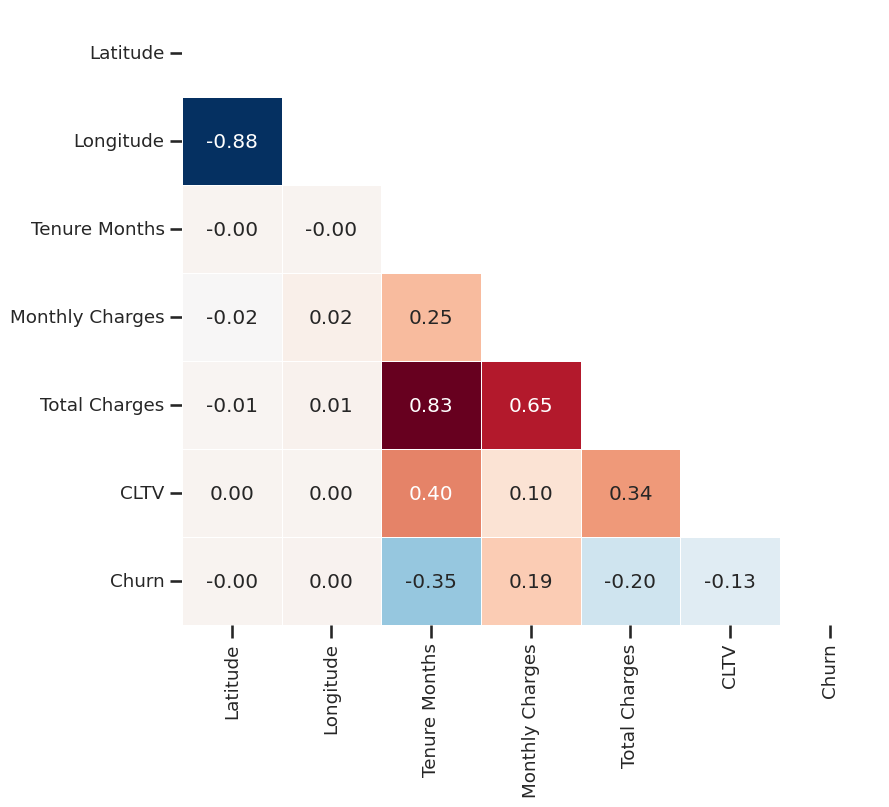

In [27]:
dfc = df.select_dtypes('number').corr()

mask = np.zeros_like(dfc).astype(bool)
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize=(9,8))
sns.heatmap(dfc, annot=True, fmt='.2f', mask=mask, cmap='RdBu_r', cbar=False, linewidths=.5)

plt.grid(False)
plt.plot()

### Mutual information

In [28]:
NUMERIC_FEATURES = [
    # 'Latitude',
    # 'Longitude',
    'Tenure Months',
    'Monthly Charges',
    'Total Charges',
    'CLTV'
]

CATEGORICAL_FEATURES = [
    # 'Gender',
    'Senior Citizen',
    'Partner',
    'Dependents',
    # 'Phone Service',
    'Multiple Lines',
    'Internet Service',
    'Online Security',
    'Online Backup',
    'Device Protection',
    'Tech Support',
    'Streaming TV',
    'Streaming Movies',
    'Contract',
    'Paperless Billing',
    'Payment Method'
]

FEATURES = NUMERIC_FEATURES + CATEGORICAL_FEATURES
TARGET = 'Churn'

In [29]:
enc = OrdinalEncoder()
X_cat = df[CATEGORICAL_FEATURES].copy()
X_cat[:] = enc.fit_transform(X_cat)

X_num = df[NUMERIC_FEATURES]
X = X_cat.join(X_num)

y = df['Churn']

X.head()

,Senior Citizen,Partner,Dependents,Multiple Lines,Internet Service,Online Security,Online Backup,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Tenure Months,Monthly Charges,Total Charges,CLTV
CustomerID,,,,,,,,,,,,,,,,,,
3668-QPYBK,0.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,2,53.85,108.15,3239
9237-HQITU,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,2,70.70,151.65,2701
9305-CDSKC,0.0,0.0,1.0,2.0,1.0,0.0,0.0,2.0,0.0,2.0,2.0,0.0,1.0,2.0,8,99.65,820.50,5372
7892-POOKP,0.0,1.0,1.0,2.0,1.0,0.0,0.0,2.0,2.0,2.0,2.0,0.0,1.0,2.0,28,104.80,3046.05,5003
0280-XJGEX,0.0,0.0,1.0,2.0,1.0,0.0,2.0,2.0,0.0,2.0,2.0,0.0,1.0,0.0,49,103.70,5036.30,5340


In [30]:
discrete_feat_array = np.hstack([
    np.repeat(True, len(CATEGORICAL_FEATURES)),
    np.repeat(False, len(NUMERIC_FEATURES))
])

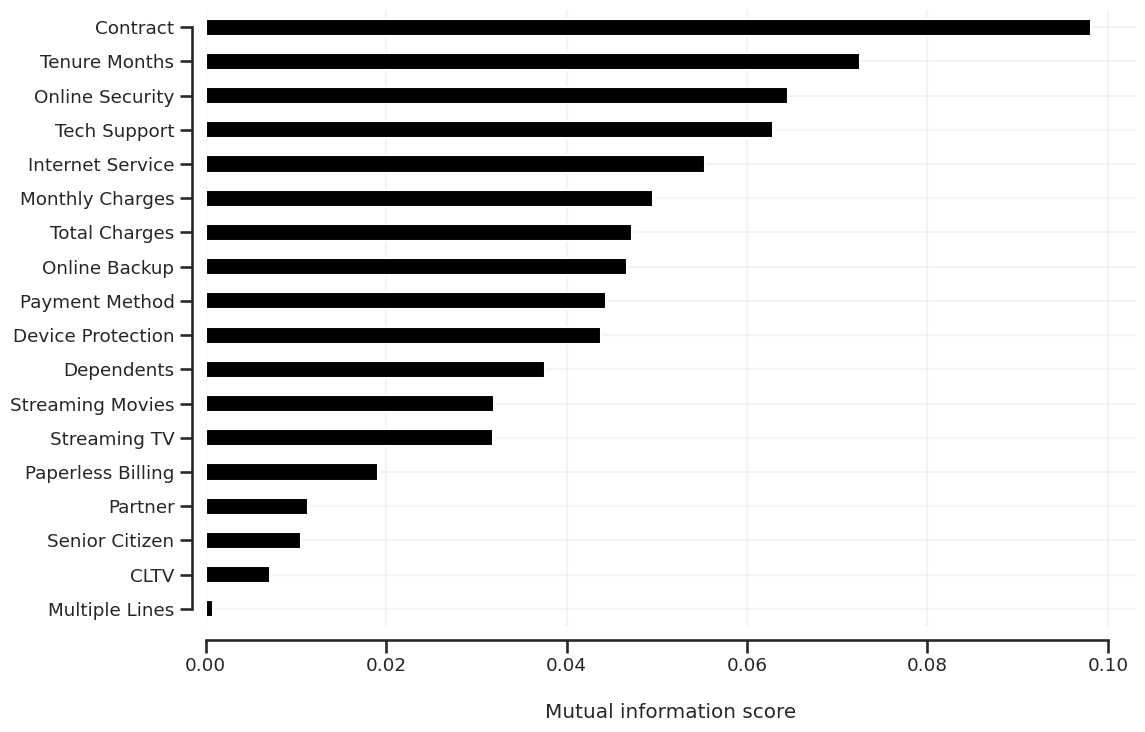

In [31]:
mi = mutual_info_classif(X, y, discrete_features=discrete_feat_array, n_neighbors=5)

pd.Series(mi, index=X.columns).sort_values(ascending=True).plot.barh(color='black') ##FFC801
plt.xlabel('Mutual information score')
sns.despine(trim=True, offset=10)

## Clustering

In [32]:
X = df[FEATURES]
y = df[TARGET]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, stratify=y, random_state=2023)

In [33]:
# K-means MinMaxScaler

cluster_kmeans_all = []

for k in range(2,11):
    
    start_time = time.time()
    cluster_pipeline = make_pipeline(
        make_column_transformer(
            [MinMaxScaler(), NUMERIC_FEATURES],
            [OneHotEncoder(drop='if_binary', sparse_output=False), CATEGORICAL_FEATURES]
        ),
        KMeans(n_clusters=k, n_init='auto', random_state=2023)
    )
    cluster_pipeline.fit(X_train)
    end_time = time.time()
    elapsed_time = end_time - start_time
    
    result_dict = {}
    clusters = cluster_pipeline.predict(X_train)
    X_transformed = cluster_pipeline[0].transform(X_train)
    df_cluster = pd.DataFrame({'churn': y_train, 'cluster': clusters})
    
    result_dict['Approach'] = 'KMEANS_ALL'
    result_dict['k'] = k
    result_dict['train_time'] = round(elapsed_time, 2)
    result_dict['wcss_score'] = cluster_pipeline.named_steps['kmeans'].inertia_
    result_dict['silhouette_score'] = metrics.silhouette_score(X_transformed, clusters)
    result_dict['information_gain'] = information_gain(df_cluster, target_col='churn', attribute_col='cluster')
    cluster_kmeans_all.append(result_dict)

In [34]:
pd.DataFrame(cluster_kmeans_all).set_index(['Approach','k']).style.background_gradient()

In [35]:
# K-means MinMaxScaler

cluster_kmeans = []

for k in range(2,11):
    
    start_time = time.time()
    cluster_pipeline = make_pipeline(
        make_column_transformer(
            [StandardScaler(), NUMERIC_FEATURES],
        ),
        KMeans(n_clusters=k, n_init='auto', random_state=2023)
    )
    cluster_pipeline.fit(X_train)
    end_time = time.time()
    elapsed_time = end_time - start_time
    
    result_dict = {}
    clusters = cluster_pipeline.predict(X_train)
    X_transformed = cluster_pipeline[0].transform(X_train)
    df_cluster = pd.DataFrame({'churn': y_train, 'cluster': clusters})
    
    result_dict['Approach'] = 'KMEANS'
    result_dict['k'] = k
    result_dict['train_time'] = round(elapsed_time, 2)
    result_dict['wcss_score'] = cluster_pipeline.named_steps['kmeans'].inertia_
    result_dict['silhouette_score'] = metrics.silhouette_score(X_transformed, clusters)
    result_dict['information_gain'] = information_gain(df_cluster, target_col='churn', attribute_col='cluster')
    cluster_kmeans.append(result_dict)

In [36]:
pd.DataFrame(cluster_kmeans).set_index(['Approach','k']).style.background_gradient()

In [37]:
# PCA All

cluster_pca_all = []

for k in range(2,11):
    
    start_time = time.time()
    
    cluster_pipeline = make_pipeline(
        make_column_transformer(
            [MinMaxScaler(), NUMERIC_FEATURES],
            [OneHotEncoder(drop='if_binary', sparse_output=False), CATEGORICAL_FEATURES]
        ),
        PCA(),
        KMeans(n_clusters=k, n_init='auto', random_state=2023)
    )
    cluster_pipeline.fit(X_train)
    end_time = time.time()
    elapsed_time = end_time - start_time
    
    result_dict = {}
    clusters = cluster_pipeline.predict(X_train)
    X_transformed = cluster_pipeline[0].transform(X_train)
    df_cluster = pd.DataFrame({'churn': y_train, 'cluster': clusters})
    
    result_dict['Approach'] = 'PCA_ALL'
    result_dict['k'] = k
    result_dict['train_time'] = round(elapsed_time, 2)
    result_dict['wcss_score'] = cluster_pipeline.named_steps['kmeans'].inertia_
    result_dict['silhouette_score'] = metrics.silhouette_score(X_transformed, clusters)
    result_dict['information_gain'] = information_gain(df_cluster, target_col='churn', attribute_col='cluster')
    cluster_pca_all.append(result_dict)

In [38]:
pd.DataFrame(cluster_pca_all).set_index(['Approach','k']).style.background_gradient()

In [39]:
# PCA

cluster_pca = []

for k in range(2,11):
    
    start_time = time.time()
    cluster_pipeline = make_pipeline(
        make_column_transformer([make_pipeline(StandardScaler(), PCA()), NUMERIC_FEATURES]),
        KMeans(n_clusters=k, n_init='auto', random_state=2023)
    )
    
    cluster_pipeline.fit(X_train)
    end_time = time.time()
    elapsed_time = end_time - start_time
    
    result_dict = {}
    clusters = cluster_pipeline.predict(X_train)
    X_transformed = cluster_pipeline[0].transform(X_train)
    df_cluster = pd.DataFrame({'churn': y_train, 'cluster': clusters})
    
    result_dict['Approach'] = 'PCA'
    result_dict['k'] = k
    result_dict['train_time'] = round(elapsed_time, 2)
    result_dict['wcss_score'] = cluster_pipeline.named_steps['kmeans'].inertia_
    result_dict['silhouette_score'] = metrics.silhouette_score(X_transformed, clusters)
    result_dict['information_gain'] = information_gain(df_cluster, target_col='churn', attribute_col='cluster')
    cluster_pca.append(result_dict)

In [40]:
pd.DataFrame(cluster_pca).set_index(['Approach','k']).style.background_gradient()

In [41]:
# MCA

cluster_mca = []

for k in range(2,11):
    
    start_time = time.time()
    cluster_pipeline = make_pipeline(
        make_column_transformer([MCA(), CATEGORICAL_FEATURES]),
        KMeans(n_clusters=k, n_init='auto', random_state=2023)
    )
    
    cluster_pipeline.fit(X_train)
    end_time = time.time()
    elapsed_time = end_time - start_time
    
    result_dict = {}
    clusters = cluster_pipeline.predict(X_train)
    X_transformed = cluster_pipeline[0].transform(X_train)
    df_cluster = pd.DataFrame({'churn': y_train, 'cluster': clusters})
    
    result_dict['Approach'] = 'MCA'
    result_dict['k'] = k
    result_dict['train_time'] = round(elapsed_time, 2)
    result_dict['wcss_score'] = cluster_pipeline.named_steps['kmeans'].inertia_
    result_dict['silhouette_score'] = metrics.silhouette_score(X_transformed, clusters)
    result_dict['information_gain'] = information_gain(df_cluster, target_col='churn', attribute_col='cluster')
    cluster_mca.append(result_dict)

In [42]:
pd.DataFrame(cluster_mca).set_index(['Approach','k']).style.background_gradient()

In [43]:
# PCA MCA

cluster_pca_mca = []

for k in range(2,11):
    
    start_time = time.time()
    cluster_pipeline = make_pipeline(
        make_column_transformer(
            [make_pipeline(StandardScaler(), PCA()), NUMERIC_FEATURES],
            [MCA(), CATEGORICAL_FEATURES]
        ),
        KMeans(n_clusters=k, n_init='auto', random_state=2023)
    )
    
    cluster_pipeline.fit(X_train)
    end_time = time.time()
    elapsed_time = end_time - start_time
    
    result_dict = {}
    clusters = cluster_pipeline.predict(X_train)
    X_transformed = cluster_pipeline[0].transform(X_train)
    df_cluster = pd.DataFrame({'churn': y_train, 'cluster': clusters})
    
    result_dict['Approach'] = 'PCA_MCA'
    result_dict['k'] = k
    result_dict['train_time'] = round(elapsed_time, 2)
    result_dict['wcss_score'] = cluster_pipeline.named_steps['kmeans'].inertia_
    result_dict['silhouette_score'] = metrics.silhouette_score(X_transformed, clusters)
    result_dict['information_gain'] = information_gain(df_cluster, target_col='churn', attribute_col='cluster')
    cluster_pca_mca.append(result_dict)

In [44]:
pd.DataFrame(cluster_pca_mca).set_index(['Approach','k']).style.background_gradient()

In [45]:
# FAMD

cluster_famd = []

for k in range(2,11):
    
    start_time = time.time()
    cluster_pipeline = make_pipeline(
        FAMD(random_state=2023),
        KMeans(n_clusters=k, n_init='auto', random_state=2023)
    )
    cluster_pipeline.fit(X_train)
    end_time = time.time()
    elapsed_time = end_time - start_time
    
    result_dict = {}
    clusters = cluster_pipeline.predict(X_train)
    X_transformed = cluster_pipeline[0].transform(X_train)
    df_cluster = pd.DataFrame({'churn': y_train, 'cluster': clusters})
    
    result_dict['Approach'] = 'FAMD'
    result_dict['k'] = k
    result_dict['train_time'] = round(elapsed_time, 2)
    result_dict['wcss_score'] = cluster_pipeline.named_steps['kmeans'].inertia_
    result_dict['silhouette_score'] = metrics.silhouette_score(X_transformed, clusters)
    result_dict['information_gain'] = information_gain(df_cluster, target_col='churn', attribute_col='cluster')
    cluster_famd.append(result_dict)

In [46]:
pd.DataFrame(cluster_famd).set_index(['Approach','k']).style.background_gradient()

In [47]:
df_clustering = pd.DataFrame(cluster_kmeans + cluster_kmeans_all + cluster_pca + cluster_pca_all + cluster_mca + cluster_pca_mca + cluster_famd).set_index(['Approach','k'])
df_clustering

train_time    wcss_score  silhouette_score  information_gain
Approach k                                                               
KMEANS   2         0.16  11107.317272          0.392884          0.025932
         3         0.19   8239.469248          0.338584          0.035736
         4         0.22   6639.487606          0.341867          0.088279
         5         0.29   5265.826491          0.361478          0.098567
         6         0.26   4663.070877          0.316518          0.094978
...                 ...           ...               ...               ...
FAMD     6         0.77  12769.675637          0.484164          0.146182
         7         1.10  10129.065104          0.456895          0.148836
         8         1.38   8774.592644          0.432332          0.152630
         9         1.08   7884.572843          0.415552          0.156522
         10        1.00   6958.372088          0.395823          0.153938

[63 rows x 4 columns]

In [48]:
# df_clustering.to_excel('../reports/tables/cluster.xlsx')

In [49]:
# FAMD
cluster_pipeline = make_pipeline(
    FAMD(n_components=20, random_state=2023),
    KMeans(n_clusters=4, n_init='auto', random_state=2023)
)

X_train['cluster'] = cluster_pipeline.fit_predict(X_train)
X_test['cluster'] = cluster_pipeline.predict(X_test)

preprocessor = make_column_transformer(
    (PowerTransformer(), NUMERIC_FEATURES),
    (OneHotEncoder(drop='if_binary'), CATEGORICAL_FEATURES+['cluster'])
)

clf = make_pipeline(preprocessor, LogisticRegressionCV(max_iter=1_000, Cs=100, class_weight='balanced', n_jobs=-1))
clf.fit(X_train, y_train)

y_pred = y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)[:,1]
get_metrics(y_test, y_pred, y_proba)

{'Accuracy': 0.7772511848341233,
 'Balanced Accuracy': 0.7937154555466179,
 'Recall': 0.8288770053475936,
 'Precison': 0.5542312276519666,
 'F1': 0.6642857142857144,
 'ROC_AUC': 0.8699408162819091}

/tmp/ipykernel_17060/3671336560.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis', 4)


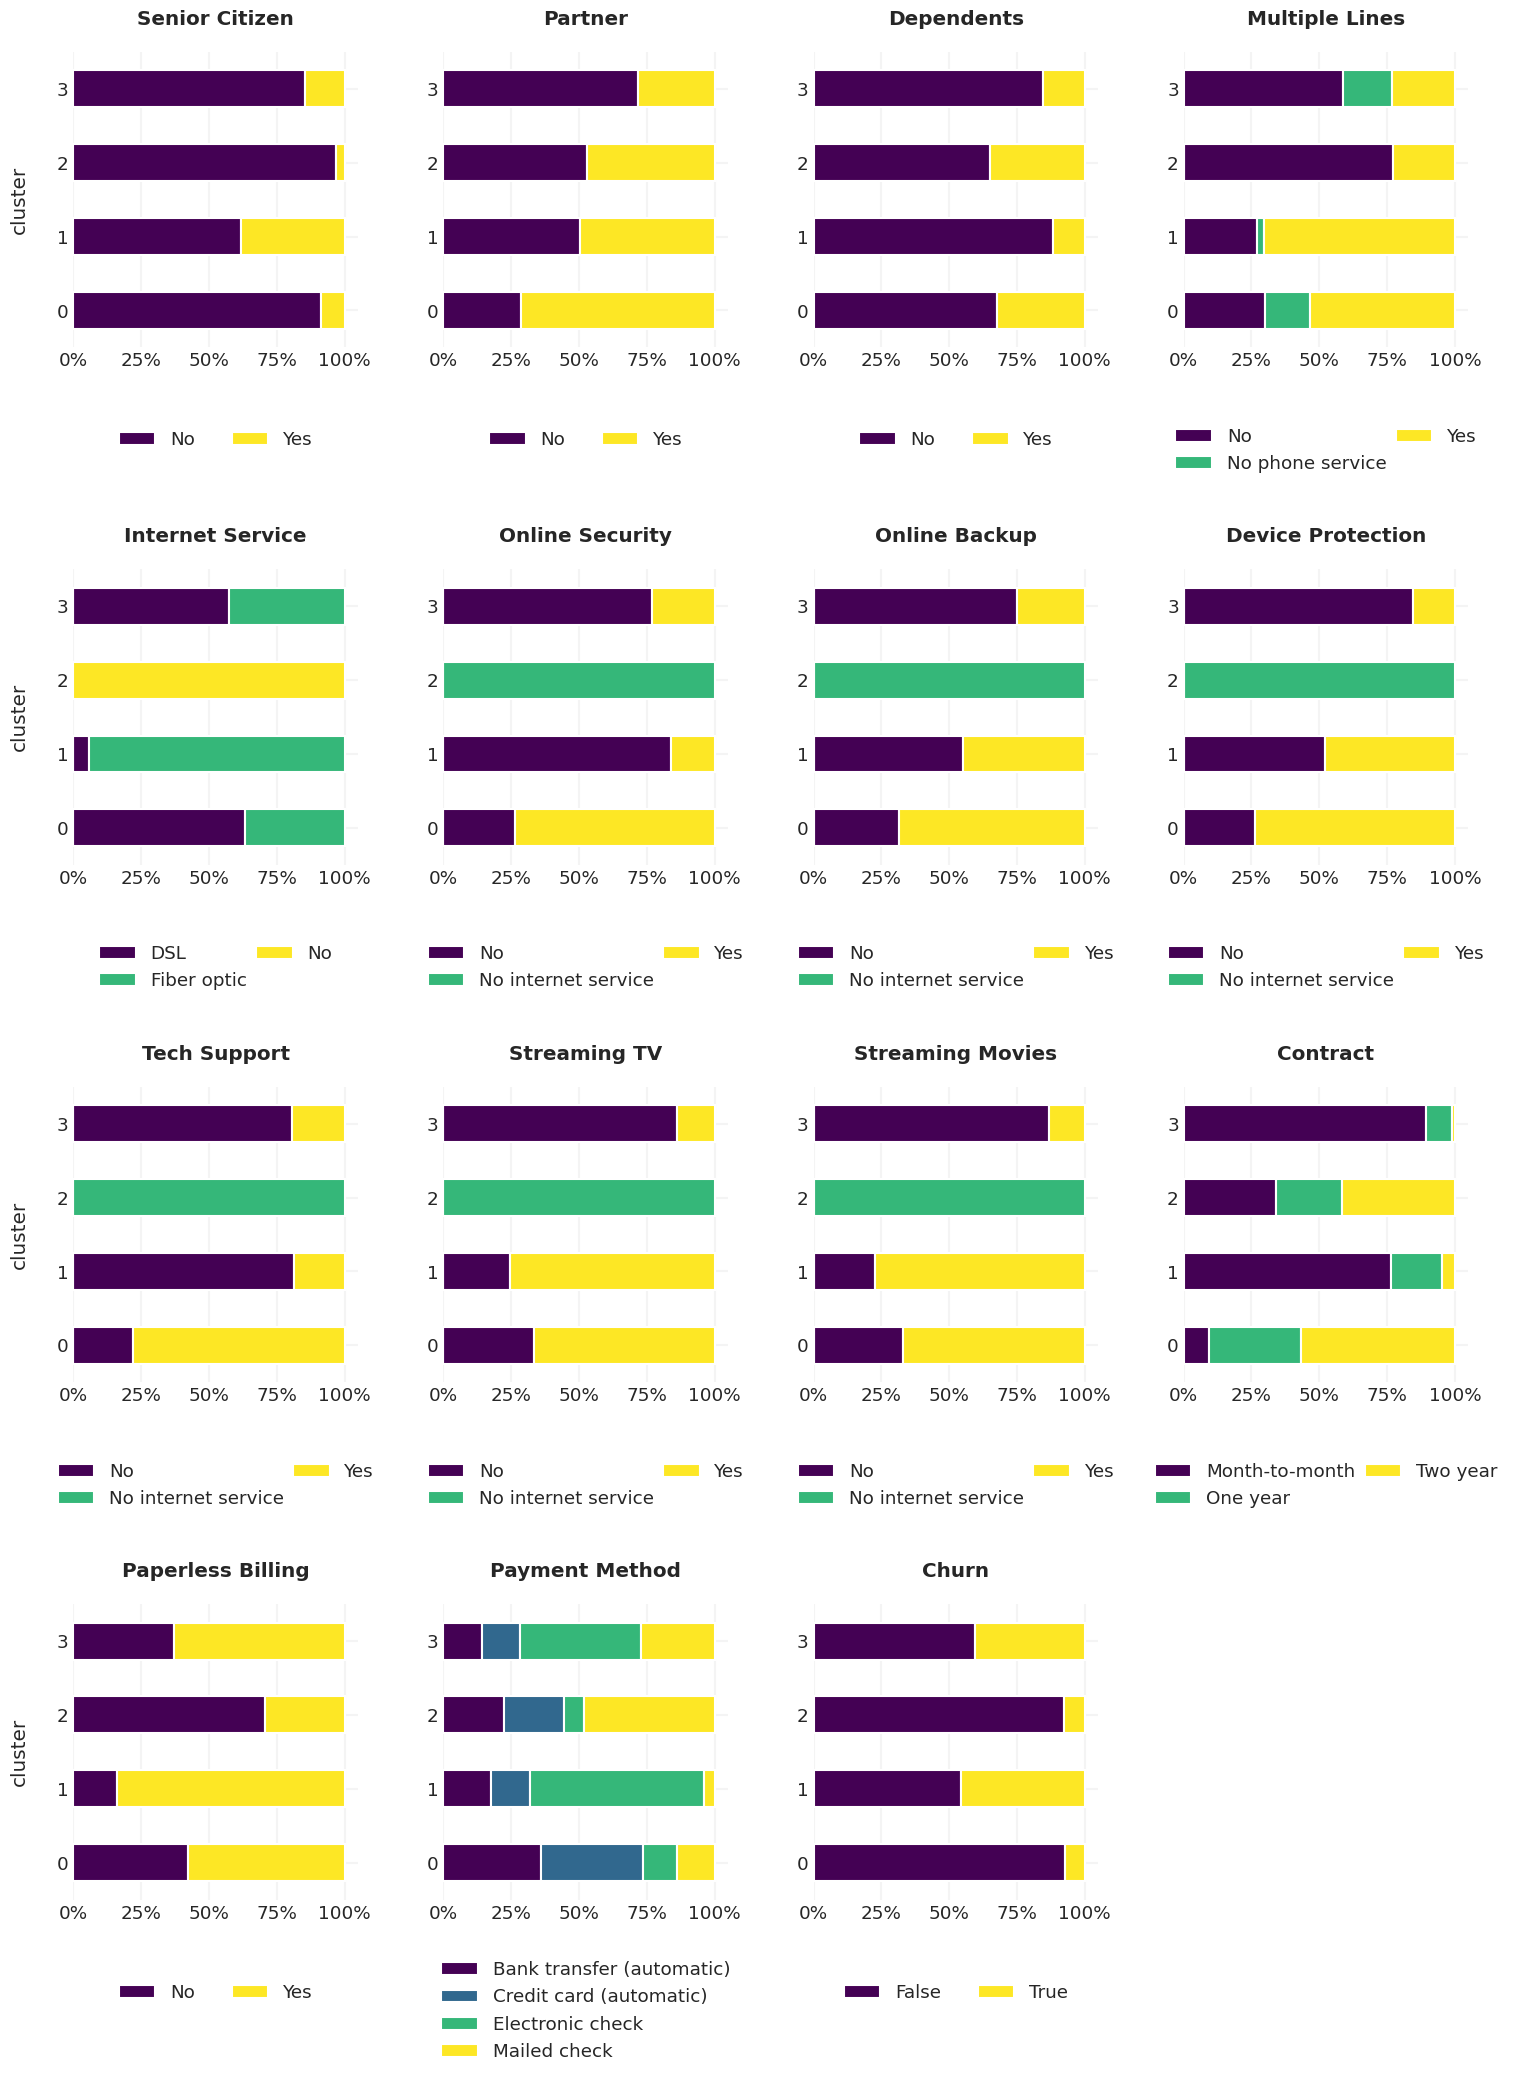

In [50]:
fig,axes = plt.subplots(nrows=4, ncols=4, figsize=(18,24))
cmap = cm.get_cmap('viridis', 4)

for i,cat in enumerate(CATEGORICAL_FEATURES+['Churn']):
    row = i // 4  # calculate the row index
    col = i % 4   # calculate the column index
    df_prop = calculate_proportion(X_train.join(y_train.astype(bool)), value_col=cat, group_col='cluster')
    df_prop = df_prop.apply(lambda x: x*100)  # convert values to percentages
    df_prop.plot(kind='barh', stacked=True, ax=axes[row, col], cmap=cmap)
    axes[row, col].set_title(cat, weight='bold', y=.95)  # set subplot title
    axes[row, col].tick_params(axis='both', which='both', length=0)
    
    # Format the y-axis tick labels as percentages
    axes[row, col].xaxis.set_major_formatter(mtick.PercentFormatter())
    
    legend = axes[row, col].legend_
    if len(legend.get_texts()) == 2:
        axes[row, col].legend(loc='lower center', bbox_to_anchor=(0.5, -0.4), ncol=2, frameon=False)
    elif len(legend.get_texts()) == 3:
        axes[row, col].legend(loc='lower center', bbox_to_anchor=(0.5, -0.48), ncol=2, frameon=False, columnspacing=0.5)
    else:
        axes[row, col].legend(loc='lower center', bbox_to_anchor=(0.5, -0.6), frameon=False, columnspacing=0.)

for i in range(4):
    for j in range(1,4):
        axes[i,j].set_ylabel(None)

axes[-1, -1].set_visible(False)
        
plt.subplots_adjust(wspace=0.3, hspace=0.75)  # adjust subplot spacing
sns.despine(trim=True, left=True, bottom=True)
plt.show()

In [51]:
calculate_proportion(X_train, 'Senior Citizen', 'cluster')

Senior Citizen,No,Yes
cluster,,
0,0.911593,0.088407
1,0.618289,0.381711
2,0.967012,0.032988
3,0.853741,0.146259


In [52]:
df_plot = X_train.pivot_table(index='cluster', columns='Senior Citizen', aggfunc='size')
df_plot = df_plot.apply(lambda x: x / x.sum(), axis=1)
display(df_plot)

Senior Citizen,No,Yes
cluster,,
0,0.911593,0.088407
1,0.618289,0.381711
2,0.967012,0.032988
3,0.853741,0.146259


In [53]:
# sns.barplot(data=X_train, x='cluster', y='Tenure Months');

In [54]:
cluster_pipeline = make_pipeline(
    make_column_transformer(
        [StandardScaler(), NUMERIC_FEATURES],
        [OneHotEncoder(drop='if_binary'), CATEGORICAL_FEATURES]
    ),
    PCA(),
    KMeans(n_clusters=3, n_init='auto', random_state=2023)
)

X_train['cluster'] = cluster_pipeline.fit_predict(X_train)
X_test['cluster'] = cluster_pipeline.predict(X_test)

preprocessor = make_column_transformer(
    (PowerTransformer(), NUMERIC_FEATURES),
    (OneHotEncoder(drop='if_binary'), CATEGORICAL_FEATURES+['cluster'])
)

clf = make_pipeline(preprocessor, LogisticRegressionCV(max_iter=1_000, Cs=100, class_weight='balanced', n_jobs=-1))
clf.fit(X_train, y_train)

y_pred = y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)[:,1]
get_metrics(y_test, y_pred, y_proba)

{'Accuracy': 0.7677725118483413,
 'Balanced Accuracy': 0.778164050408003,
 'Recall': 0.8003565062388592,
 'Precison': 0.5429262394195888,
 'F1': 0.6469740634005763,
 'ROC_AUC': 0.8645771120232822}

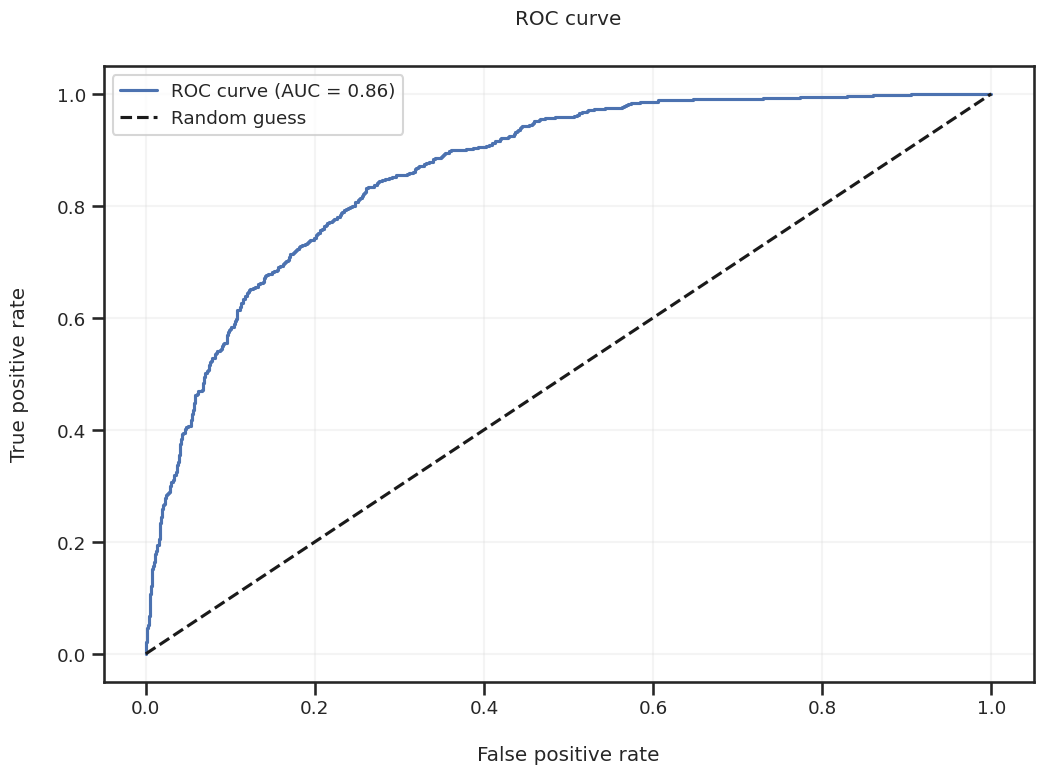

In [55]:
from sklearn.metrics import roc_curve, roc_auc_score

# Predict the probabilities of positive class for the test data
y_proba = clf.predict_proba(X_test)[:, 1]

# Compute the TPR and FPR for different classification thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

# Compute the AUC score
auc_score = roc_auc_score(y_test, y_proba)

# Plot the ROC curve
plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % auc_score)
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [56]:
# Predict the probabilities of positive class for the test data
y_proba = clf.predict_proba(X_test)[:, 1]

# Compute the TPR and FPR for different classification thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

# Compute the Youden's J statistic for different classification thresholds
youden = tpr - fpr

# Find the threshold that maximizes the Youden's J statistic
optimal_idx = np.argmax(youden)
optimal_threshold = thresholds[optimal_idx]

# Compute the predicted class labels for the test data using the optimal threshold
y_pred = (y_proba >= optimal_threshold).astype(int)

# Print metrics
print("Optimal threshold:", optimal_threshold)
get_metrics(y_test, y_pred)

Optimal threshold: 0.4825662885705443


{'Accuracy': 0.7639810426540284,
 'Balanced Accuracy': 0.7858143198590546,
 'Recall': 0.8324420677361853,
 'Precison': 0.5361653272101033,
 'F1': 0.6522346368715084}